In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

In [2]:
source_path = 'data/garbage_classification_6_classes/garbage_classification/'

source_path_cardboard = os.path.join(source_path, 'cardboard')
source_path_glass = os.path.join(source_path, 'glass')
source_path_metal = os.path.join(source_path, 'metal')
source_path_paper = os.path.join(source_path, 'paper')
source_path_plastic = os.path.join(source_path, 'plastic')
source_path_trash = os.path.join(source_path, 'trash')

# Functions

## Display images

In [3]:
def display_image(img, title=None):
    """ Function to display an image
    Args:
        1) img - image object
        2) title - the title that will be displayed above the image
    Returns:
        None; but displays an image
    """
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [4]:
def display_original_augmented_img(original_img, augmented_img, original_title=None, augmented_title=None):
    """ Function to display the original and augmented image on the same graph
    Args:
        1) original_img - object of the original image
        2) augmented_img - augmented image object
        3) original_title - title for the original image
        4) augmented_title - title for the augmented image
    Returns:
        None; but displays images
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_img)
    axes[0].set_title(original_title)
    
    axes[1].imshow(augmented_img)
    axes[1].set_title(augmented_title)
    plt.show()

## Perform image augmentation using ImageDataGenerator

In [5]:
def perform_ImageDataGen_augmentation(imageDataGenerator, images, image_filenames, target_size, 
                                      augm_prefix, num_augm_images=3, augm_images_dir_path=None, 
                                      save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) imageDataGenerator - ImageDataGenerator class object
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """
    augmented_index = 0
    for (image_name, img) in zip(image_filenames, images):
        x = img.copy()
        x = np.expand_dims(x, axis=0)

        i = 0
        for batch in datagen.flow(x, batch_size=1):
            i += 1
            if i > num_augmented_images:
                augmented_index = 0
                break 
            
            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"
        
            augmented_index += 1
            
            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augmented_images_dir, exist_ok=True)
                augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
                # tf.keras.preprocessing.image.save_img(augmented_image_path, batch[0])
                cv2.imwrite(augmented_image_path, cv2.cvtColor(batch[0].copy().astype(np.uint8), cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=batch[0].copy().astype(np.uint8), 
                                               original_title=f"Original_image: {image_name}", 
                                               augmented_title=f"{augm_prefix}: {image_name}")

## Perform image augmentation using CV2

### Augmentation functions

In [6]:
def get_width_shift_image(image, width_shift_fraction):
    """ Function for performing width_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) width_shift_fraction - offset value ([-1; 1])
    Returns:
        augmented_image
    """
    # Get the height and width of the image
    height, width = image.shape[:2]

    # Calculate the height shift value
    width_shift = int(height * width_shift_fraction)

    # Calculate the new y-coordinate for height shift
    y_shifted = height // 2 + width_shift

    # Calculate the rotation matrix for height shift
    shift_matrix = np.float32([[1, 0, 0], [0, 1, width_shift]])

    # Apply the height shift to the image using warpAffine
    changed_image = cv2.warpAffine(image, shift_matrix, (width, height))
    return changed_image

In [7]:
def get_height_shift_image(image, height_shift_fraction):
    """ Function for performing height_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) height_shift_fraction - offset value ([-1; 1])
    Returns:
        augmented_image
    """
    # Get the height and width of the image
    height, width = image.shape[:2]

    # Calculate the height shift value
    height_shift = int(width * height_shift_fraction)

    # Calculate the new x-coordinate for height shift
    x_shifted = width // 2 + height_shift

    # Calculate the rotation matrix for height shift
    shift_matrix = np.float32([[1, 0, height_shift], [0, 1, 0]])

    # Apply the height shift to the image using warpAffine
    changed_image = cv2.warpAffine(image, shift_matrix, (width, height))
    return changed_image

In [8]:
def get_brightness_augmentation_image(image, brightness_range=(0.5, 1.5)):
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Generate a random brightness factor within the specified range
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
    
    # Adjust the brightness by scaling the V channel
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * brightness_factor, 0, 255)
    
    # Convert the image back to the original color space (BGR)
    augmented_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return augmented_image

In [9]:
def get_contrast_augmentation_image(image, contrast_factor):
    """ Function for performing height_shift augmentation over the image 'image'
    Args:
        1) image - image object
        2) contrast_factor - adjusts the contrast of the image by applying CLAHE; possible values: [1.0; 4.0]
    Returns:
        augmented_image
    """
    # Convert the image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel
    clahe = cv2.createCLAHE(clipLimit=contrast_factor, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Merge the CLAHE enhanced L channel with the original A and B channels
    limg = cv2.merge((cl, a, b))
    
    # Convert the LAB image back to BGR color space
    contrast_augmented_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return contrast_augmented_image

In [79]:
def get_hsv_image(image, hue_shift, saturation_scale=1, value_scale=1):
    """ Function to change the color tone of the image when switching to the HSV model
    Args:
        1) image - image object
        2) hue_shift - the value of the Hue parameter of the hsv model; possible values: [0; 179] (OpenCV)
        3) saturation_scale - coefficient by which the Saturation parameter of the HSV model will be multiplied
        4) value_scale - coefficient by which the Value parameter of the HSV model will be multiplied 
    Returns:
        augmented_image
    """
    # Convert the original image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply the hue shift to the hue channel
    hsv_image[:, :, 0] = (hsv_image[:, :, 0] + hue_shift) % 180
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * saturation_scale, 0, 255)
    hsv_image[:, :, 2] = np.clip(hsv_image[:, :, 2] * value_scale, 0, 255)
    
    # Convert the image back to the RGB color space
    augmented_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return augmented_image

### Augmentation algorithms

In [10]:
def perform_cv2_rotation_augmentation(rotation_range, images, image_filenames, 
                                      target_size, augm_prefix, 
                                      num_augm_images=3, augm_images_dir_path=None, 
                                      save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) rotation_range - the range (a list of two elements: [range_min; range_max]) in which the angle value will change linearly (depending on num_augm_images) 
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """
    height = target_size[0]
    width = target_size[1]
    angle_increment = int((rotation_range[1] - rotation_range[0]) / num_augm_images)
    for (image_name, img) in zip(image_filenames, images):
        augmented_index = 0
        angle = rotation_range[0]
        for i in range(num_augm_images):
            # Calculate the rotation matrix
            rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

            # Apply the rotation to the image using warpAffine
            augmented_image = cv2.warpAffine(img, rotation_matrix, (width, height))
            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"
            augmented_index += 1
            angle += angle_increment
            if angle == 0:
                angle += angle_increment
                
            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augmented_images_dir, exist_ok=True)
                augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
                cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=augmented_image, 
                                               original_title=f"Original_image: {image_name}", 
                                               augmented_title=f"{augm_prefix}: {image_name}")

In [11]:
def perform_cv2_flip_augmentation(flip_code, images, image_filenames, 
                                  target_size, augm_prefix, 
                                  num_augm_images=3, augm_images_dir_path=None, 
                                  save_augm_image=True, display_orig_augm_images=False):
    """ Function to create augmented images from images using imageDataGenerator
    Args:
        1) flip_code - the type of flip augmentation to perform on the image: 0 - vertical, 1 - horizontal 
        2) images - a list of images, each of which is stored as a numpy array
        3) image_filenames - a list of image file names images (the names are used in the headers of the images that will be saved)
        4) target_size - the size of the images
        5) augm_prefix - prefix to be added to the beginning of the file name to indicate the augmentation technique
        6) num_augm_images - the number of instances of augmented images for one original
        7) augm_images_dir_path - the path to the folder where you want to save the augmented images (used if save_augm_image=True)
        8) save_augm_image - whether to save the augmented image
        9) display_orig_augm_images - whether to display the original and augmented image at the same time (original - left, augmented - right)
    Returns:
        None; but saves or displays augmented_images
    """
    
    for (image_name, img) in zip(image_filenames, images):
        augmented_index = 0
        for i in range(num_augm_images):
            augmented_image = cv2.flip(img.copy(), flip_code)
                    
            augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_{augmented_index}.jpg"
            augmented_index += 1
            
            if save_augm_image and (augm_images_dir_path is not None):
                os.makedirs(augmented_images_dir, exist_ok=True)
                augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
                cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            if display_orig_augm_images:
                display_original_augmented_img(original_img=img, augmented_img=augmented_image, 
                                               original_title=f"Original_image: {image_name}", 
                                               augmented_title=f"{augm_prefix}: {image_name}")

# View test data

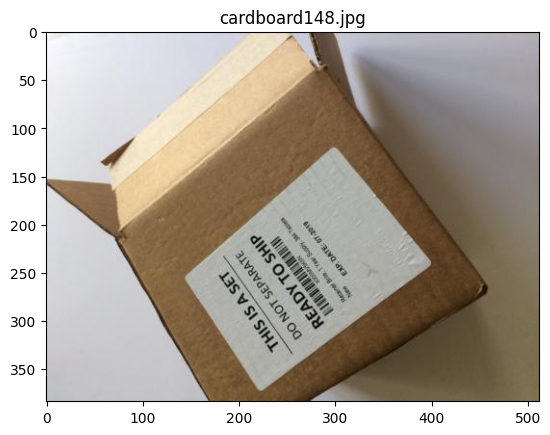

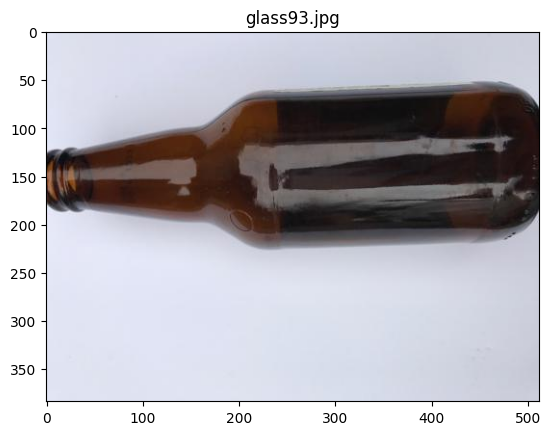

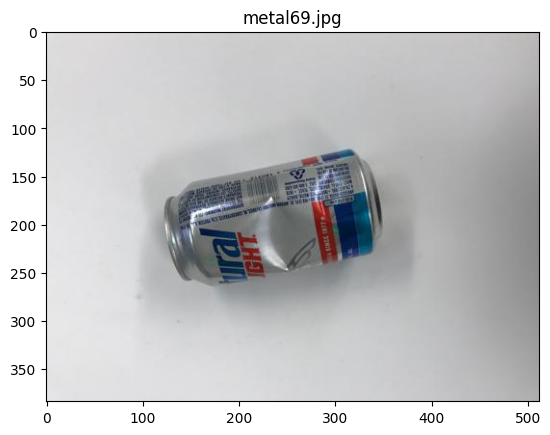

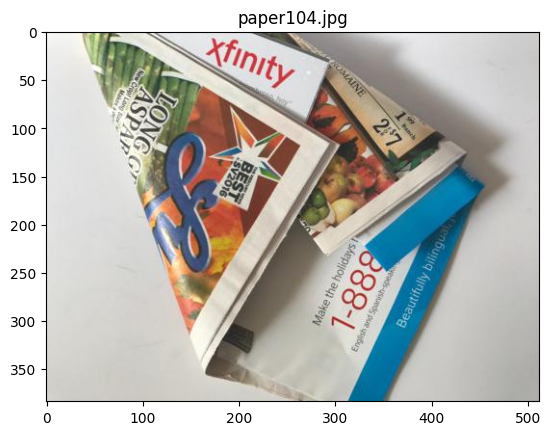

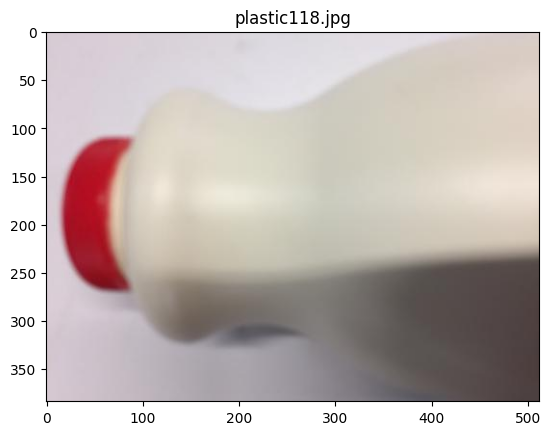

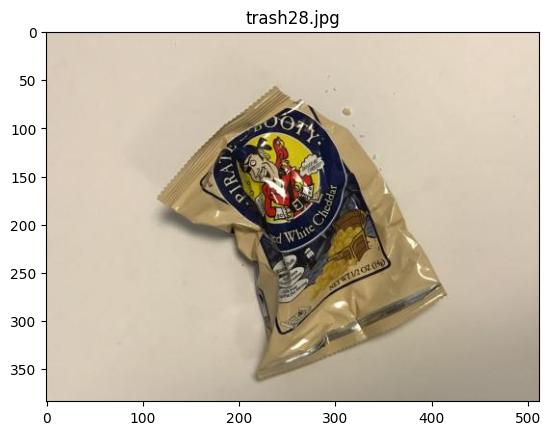

In [62]:
image_filepaths = [source_path_cardboard, source_path_glass, source_path_metal, source_path_paper, source_path_plastic, 
                   source_path_trash]
image_filenames = ['cardboard148.jpg', 'glass93.jpg', 'metal69.jpg', 'paper104.jpg', 'plastic118.jpg',
                  'trash28.jpg']
augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'
show_images = True
images = []
for image_filepath, image_filename in zip(image_filepaths, image_filenames):
    img = cv2.imread(os.path.join(image_filepath, image_filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    
    if show_images:
        display_image(img, title=image_filename)

# Perform image augmentation using ImageDataGenerator and cv2 algorithms 

In [13]:
# Get the size of the image (height, width)
img_height, img_width = img.shape[:2]
print(f"img_height = {img_height}, img_width = {img_width}")

img_height = 384, img_width = 512


## rotation

### ImageDataGenerator -

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    fill_mode='constant'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 3

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_Rotation', num_augm_images=num_augmented_images, 
                                  save_augm_image=True)

### CV2 algorithm +

In [ ]:
target_size = (img_height, img_width)
perform_cv2_rotation_augmentation(rotation_range=[-30, 30], images=images, 
                                  image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_Rotation', num_augm_images=6, 
                                  save_augm_image=True, display_orig_augm_images=True)

## width_shift

### ImageDataGenerator -

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    width_shift_range=(0.1, 0.1),
    fill_mode='constant'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 3

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_wShift', num_augm_images=num_augmented_images, 
                                  save_augm_image=True)

### CV2 algorithm +

In [ ]:
width_shift_fraction = 0.1
for image, image_name in zip(images, image_filenames):
    augmented_image = get_width_shift_image(image=image, width_shift_fraction=width_shift_fraction)
    
    display_original_augmented_img(original_img=image, augmented_img=augmented_image,
                                   original_title=f"Original_img: {image_name}",
                                   augmented_title=f"wShifted_img: {image_name}")
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    
    augmented_image = get_width_shift_image(image=image, width_shift_fraction=(-width_shift_fraction))
    display_original_augmented_img(original_img=image, augmented_img=augmented_image,
                                   original_title=f"Original_img: {image_name}",
                                   augmented_title=f"wShifted_img: {image_name}")
    augmented_image_name = f"aug_wShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

## height_shift

### ImageDataGenerator -

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    height_shift_range=0.2,
    fill_mode='nearest'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_hShift', num_augm_images=num_augmented_images, 
                                  save_augm_image=True)

### CV2 algorithm +

In [ ]:
height_shift_fraction = 0.15
for image, image_name in zip(images, image_filenames):
    augmented_image = get_height_shift_image(image=image, height_shift_fraction=height_shift_fraction)
    
    display_original_augmented_img(original_img=image, augmented_img=augmented_image,
                                   original_title=f"Original_img: {image_name}",
                                   augmented_title=f"hShifted_img: {image_name}")
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_0.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    
    augmented_image = get_height_shift_image(image=image, height_shift_fraction=(-height_shift_fraction))
    display_original_augmented_img(original_img=image, augmented_img=augmented_image,
                                   original_title=f"Original_img: {image_name}",
                                   augmented_title=f"hShifted_img: {image_name}")
    augmented_image_name = f"aug_hShift_{image_name.split('.')[0]}_1.jpg"
    augmented_image_path = os.path.join(augmented_images_dir, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))

## horizontal_flip

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    horizontal_flip=True,
    fill_mode='constant'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_hFlip', num_augm_images=num_augmented_images, 
                                  save_augm_image=False, display_orig_augm_images=True)

In [ ]:
for img, image_filename in zip(images, image_filenames):
    display_image(img, title=image_filename)

### CV2 algorithm +

In [ ]:
num_augmented_images = 1
perform_cv2_flip_augmentation(flip_code=1, images=images, image_filenames=image_filenames, 
                              augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                              augm_prefix='aug_hFlip', num_augm_images=num_augmented_images, 
                              save_augm_image=True, display_orig_augm_images=True)

## vertical_flip

### ImageDataGenerator -

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    vertical_flip=True,
    fill_mode='constant'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_vFlip', num_augm_images=num_augmented_images, 
                                  save_augm_image=True, display_orig_augm_images=True)

### CV2 algorithm +

In [ ]:
num_augmented_images = 1
perform_cv2_flip_augmentation(flip_code=0, images=images, image_filenames=image_filenames, 
                              augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                              augm_prefix='aug_vFlip', num_augm_images=num_augmented_images, 
                              save_augm_image=True, display_orig_augm_images=True)

## zoom = scaling

### Enlarge the image (bring it closer to the viewer) - ImageDataGenerator +

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(0.8, 1),
    fill_mode='constant'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_iZoom', num_augm_images=num_augmented_images, 
                                  save_augm_image=True, display_orig_augm_images=True)

### Reduce the image (move it away from the viewer) - ImageDataGenerator +

In [ ]:
# Define your augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=(1, 1.2),
    fill_mode='constant'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_dZoom', num_augm_images=num_augmented_images, 
                                  save_augm_image=True, display_orig_augm_images=True)

## brightness_shift

### ImageDataGenerator +

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(0.5, 0.5),
    fill_mode='nearest'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_blackBrightness', num_augm_images=num_augmented_images, 
                                  save_augm_image=True, display_orig_augm_images=True)

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(1.25, 1.25),
    fill_mode='nearest'
)

augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

os.makedirs(augmented_images_dir, exist_ok=True)

target_size = (img_height, img_width)

num_augmented_images = 1

perform_ImageDataGen_augmentation(imageDataGenerator=datagen, images=images, image_filenames=image_filenames, 
                                  augm_images_dir_path=augmented_images_dir, target_size=target_size, 
                                  augm_prefix='aug_ligthBrightness', num_augm_images=num_augmented_images, 
                                  save_augm_image=True, display_orig_augm_images=True)

### CV2 algorithm

In [ ]:
augm_prefix = 'aug_blackBrightness'
for img, image_name in zip(images, image_filenames):
    changed_image = apply_brightness_augmentation(image=img, brightness_range=(0.5, 0.5))
    augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_0.jpg"
    cv2.imwrite(os.path.join(augmented_images_dir, augmented_image_name), cv2.cvtColor(changed_image, cv2.COLOR_BGR2RGB))
    display_original_augmented_img(original_img=img, augmented_img=changed_image, 
                                   original_title=f"Original_img: {image_name}",
                                   augmented_title=f"Brightness_img: {image_name}")

## contrast augmentation

In [ ]:
augm_prefix = 'aug_Contrast'
for image, image_name in zip(images, image_filenames):
    augmented_image = get_contrast_augmentation_image(image=image, contrast_factor=2.0)
    augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_0.jpg"
    cv2.imwrite(os.path.join(augmented_images_dir, augmented_image_name), cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    display_original_augmented_img(original_img=image, augmented_img=augmented_image, 
                                   original_title=f"Original_img: {image_name}",
                                   augmented_title=f"Brightness_img: {image_name}")

## backgrounds augmentation

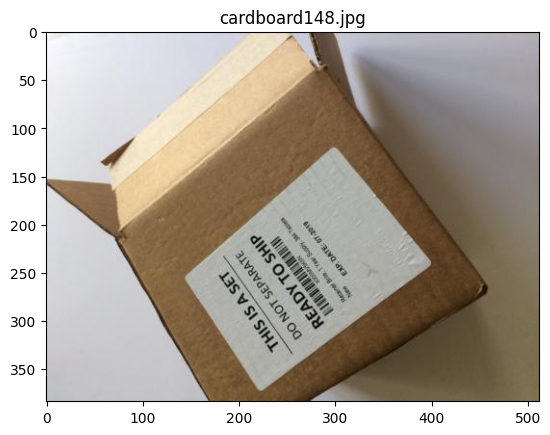

garbage_img_height = 384, garbage_img_width = 512


In [47]:
image_filepaths = [source_path_cardboard, source_path_glass, source_path_metal, source_path_paper, source_path_plastic, 
                   source_path_trash]
image_filenames = ['cardboard148.jpg', 'glass93.jpg', 'metal69.jpg', 'paper104.jpg', 'plastic118.jpg',
                  'trash28.jpg']
augmented_images_dir = 'data/garbage_classification_6_classes/garbage_classification_augmentation_test/'

garbage_img = cv2.imread(os.path.join(image_filepaths[0], image_filenames[0]))
garbage_img = cv2.cvtColor(garbage_img, cv2.COLOR_BGR2RGB)

display_image(img=garbage_img, title=image_filenames[0]) 

# Get the size of the garbage image (height, width)
garbage_img_height, garbage_img_width = garbage_img.shape[:2]
print(f"garbage_img_height = {garbage_img_height}, garbage_img_width = {garbage_img_width}")

In [ ]:
background_image_filepath = 'data/backgrounds/'
background_image_names = os.listdir(background_image_filepath+'original/')
background_images = []
show_images = True

for background_image_name in background_image_names:
    background_image = cv2.imread(os.path.join(background_image_filepath+'original/', background_image_name))
    background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    background_image = cv2.resize(background_image, (garbage_img_width, garbage_img_height))
    background_images.append(background_image)
    
    resized_image_name = f"{background_image_name.split('.')[0]}_reized.jpg"
    cv2.imwrite(os.path.join(background_image_filepath+'resized/', resized_image_name), 
                cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB))
    if show_images:
        display_image(background_image, title=background_image_name)

In [54]:
background_images[0].shape

(384, 512, 3)

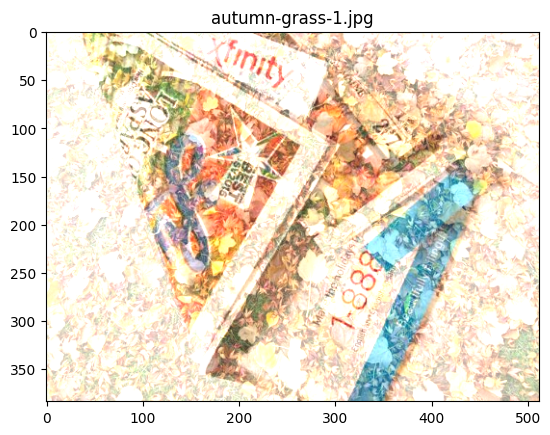

In [82]:
garbage_image = images[3]
background_image = background_images[0]

# Adjust the transparency (alpha channel) of the garbage image
alpha = 0.9  # Adjust this value between 0 (completely transparent) and 1 (completely opaque)
garbage_image = cv2.addWeighted(garbage_image, alpha, np.zeros_like(garbage_image), 1 - alpha, 0)

background_alpha = 0  # Adjust this value between 0 (completely transparent) and 1 (completely opaque)
background_image = cv2.addWeighted(background_image, alpha, np.zeros_like(background_image), 1 - background_alpha, 0)

# Overlay the resized garbage image onto the resized background image
augmented_image = cv2.addWeighted(background_image, 1, garbage_image, 1, 0)

display_image(augmented_image, title=background_image_names[0])

## color space transformations (HSV) augmentation

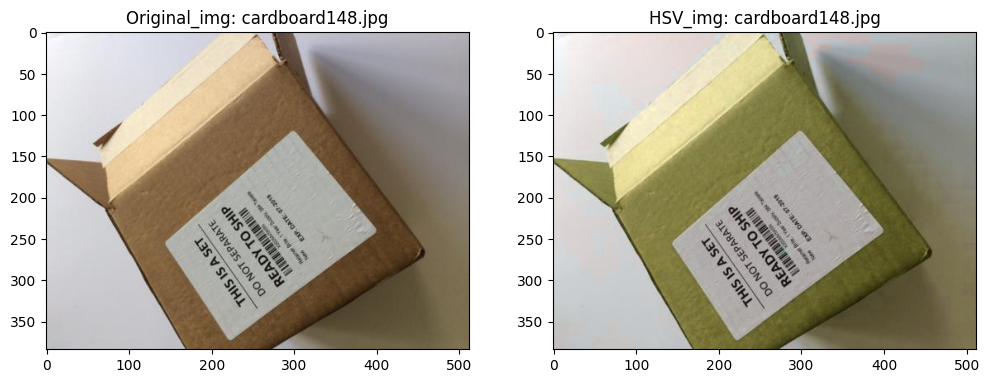

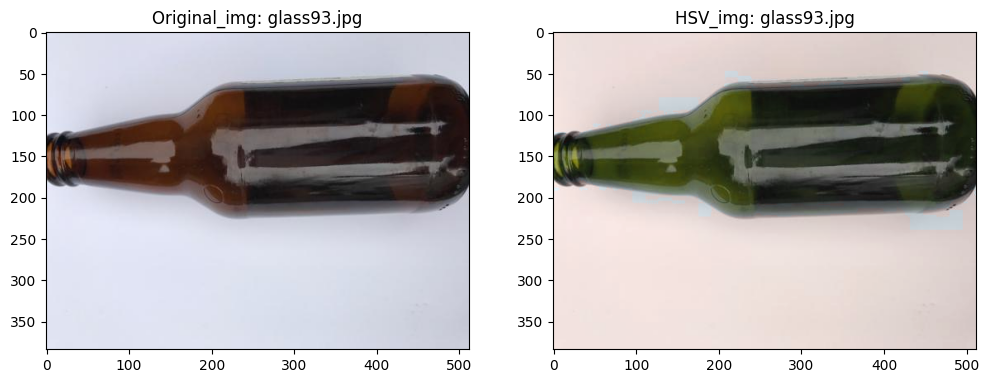

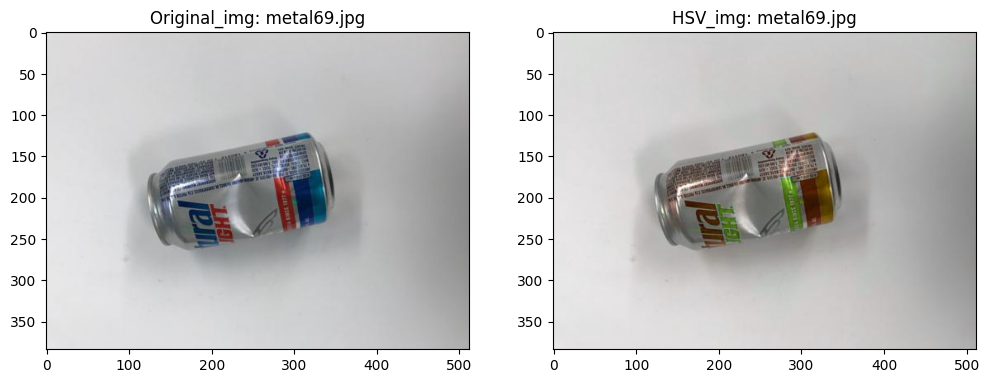

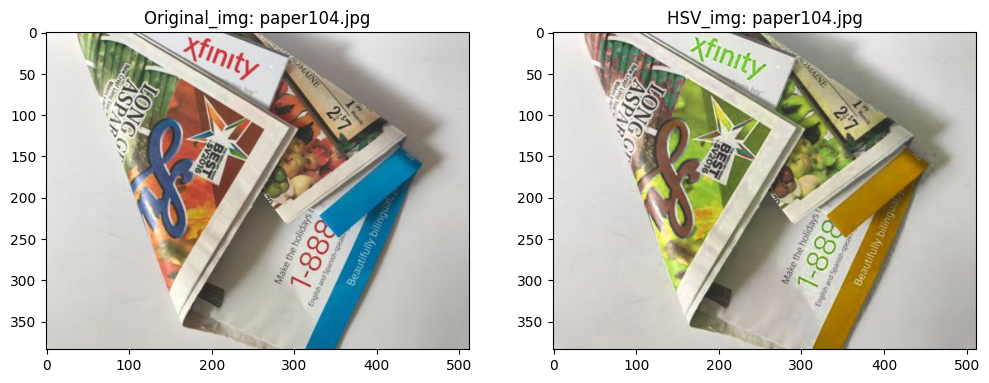

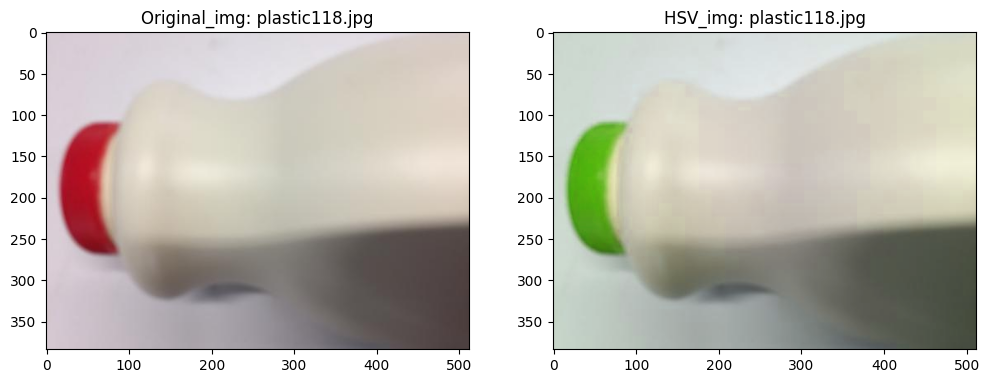

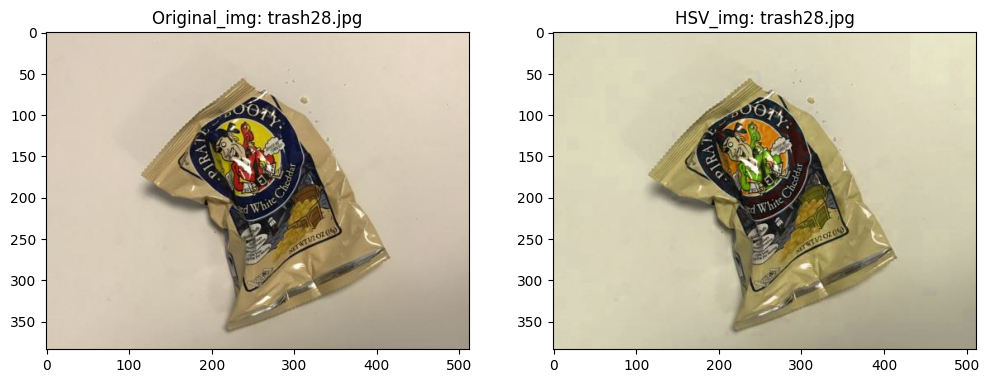

In [89]:
augm_prefix = 'aug_hsv'
for image, image_name in zip(images, image_filenames):
    augmented_image = get_hsv_image(image=image, hue_shift=180)
    augmented_image_name = f"{augm_prefix}_{image_name.split('.')[0]}_0.jpg"
    cv2.imwrite(os.path.join(augmented_images_dir, augmented_image_name), cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    display_original_augmented_img(original_img=image, augmented_img=augmented_image, 
                                   original_title=f"Original_img: {image_name}",
                                   augmented_title=f"HSV_img: {image_name}")